In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# read all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(words)

In [6]:
# build the dataset
block_size = 8 # context length : how many characters do we take to pedioct the next one

def build_dataset(words):
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] #crop and append
        
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182580, 8]) torch.Size([182580])
torch.Size([22767, 8]) torch.Size([22767])
torch.Size([22799, 8]) torch.Size([22799])


In [7]:
for x,y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> e
.......e --> b
......eb --> r
.....ebr --> i
....ebri --> m
...ebrim --> a
..ebrima --> .
........ --> h
.......h --> i
......hi --> l
.....hil --> t
....hilt --> o
...hilto --> n
..hilton --> .
........ --> j
.......j --> h
......jh --> e
.....jhe --> n
....jhen --> e
...jhene --> .


In [8]:
class Linear:
    
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note : kaiming initialisation
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
    
class BatchNorm1d:
    
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running momentum update)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalie to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []
    
    
class Embedding:
    
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))
        
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self):
        return [self.weight]
    
    
class Flatten:
    
    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out
    
    def parameters(self):
        return []
    
    
class Sequential:
    
    def __init__(self, layers):
        self.layers = layers
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        # get parameters of all layers stretch them out into one list
        return [p for layer in self.layers for p in layer.parameters()]

In [9]:
torch.manual_seed(42); # seed rng for reproducibility

In [11]:
n_embd = 10 # the dimensionality of the character embedding vector
n_hidden = 200 # the number of neurons in the hidden layer of MLP

C = torch.randn((vocab_size, n_embd))
model = Sequential([
    Embedding(vocab_size, n_embd),
    Flatten(),
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

# parameter init 
with torch.no_grad():
    model.layers[-1].weight *= 0.1 # last layer make less confident
    
parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

22097


In [20]:
ix = torch.randint(0, Xtr.shape[0], (4, )) # let's look at a batch of just 4 examples
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0, 11,  1, 12,  1, 25,  1],
        [ 0,  0, 23,  9, 14, 20, 15, 14],
        [ 0,  0,  5, 12, 12,  5,  1, 14],
        [ 0,  0,  0,  0,  0,  0,  0, 10]])

In [21]:
model.layers[0].out.shape # output of Embedding layer

torch.Size([4, 8, 10])

In [22]:
model.layers[1].out.shape # output of the Flatten layer

torch.Size([4, 80])

In [23]:
model.layers[2].out.shape # output of the Flatten layer

torch.Size([4, 200])

In [12]:
# optimization step
max_steps = 200000
batch_size = 32
lossi= []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y
    
    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb) # loss function
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update : simple SGD
    lr = 0.1 if i<15000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 1000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d} : {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000 : 3.3008
   1000/ 200000 : 2.9026
   2000/ 200000 : 1.8909
   3000/ 200000 : 2.3492
   4000/ 200000 : 2.4706
   5000/ 200000 : 2.4982
   6000/ 200000 : 2.3088
   7000/ 200000 : 1.8686
   8000/ 200000 : 1.9744
   9000/ 200000 : 2.2860
  10000/ 200000 : 2.0881
  11000/ 200000 : 2.0999
  12000/ 200000 : 2.6393
  13000/ 200000 : 2.4705
  14000/ 200000 : 2.1491
  15000/ 200000 : 1.9801
  16000/ 200000 : 2.1840
  17000/ 200000 : 1.9195
  18000/ 200000 : 1.7247
  19000/ 200000 : 2.0445
  20000/ 200000 : 2.0937
  21000/ 200000 : 2.0025
  22000/ 200000 : 1.9131
  23000/ 200000 : 2.0220
  24000/ 200000 : 2.0694
  25000/ 200000 : 2.1469
  26000/ 200000 : 2.2497
  27000/ 200000 : 2.3720
  28000/ 200000 : 1.9756
  29000/ 200000 : 2.4836
  30000/ 200000 : 2.1289
  31000/ 200000 : 1.9365
  32000/ 200000 : 2.0528
  33000/ 200000 : 1.8148
  34000/ 200000 : 2.0788
  35000/ 200000 : 2.1342
  36000/ 200000 : 1.9765
  37000/ 200000 : 2.5611
  38000/ 200000 : 2.0678
  39000/ 200000 : 1.8641


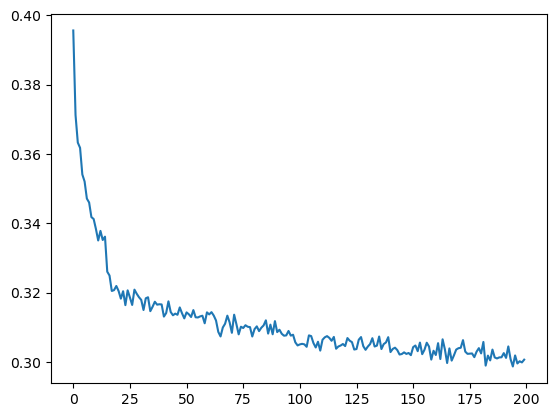

In [13]:
# loss averaged over every 1000 steps for a smoother curve.
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [14]:
# put layer into eval mode (needed for batchnorm especially)
for layer in model.layers:
    layer.training = False

In [18]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking in pytorch
def split_loss(split):
    x, y ={
        'train' : (Xtr, Ytr),
        'val' : (Xdev, Ydev),
        'text' : (Xte, Yte),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('val')

train 1.9739749431610107
val 2.0577869415283203


In [19]:
# sample from the model

for _ in range(20):
    out = []
    context = [0] * block_size # (1, block_size, n_embd)
    while True:
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix==0:
            break
        
    print(''.join(itos[i] for i in out)) # decode and print the generated word

kilynn.
kaden.
lukien.
tiesce.
alani.
cemello.
larym.
kashi.
zaon.
emmierose.
bleyliys.
daylou.
viday.
jaksiel.
ambron.
makton.
klaley.
jaslumuan.
maelyn.
tyk.
